In [4]:
%load_ext autoreload
%autoreload 

import sys
import os
classes_path = os.path.abspath('../h5tests/')
sys.path.append(classes_path)
from xarray_arr_mean import XarrayArrMean
import pandas as pd

import xarray as xr
import h5py
import s3fs

benchmarks = []

for library in (xr, h5py, s3fs):
    print(f'{library.__name__} v{library.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
xarray v2024.1.1
h5py v3.10.0
s3fs v2024.2.0


In [11]:
files = [
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5",
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/original/ATL03_20190219140808_08110212_006_02.h5",
]
xarray_original = XarrayArrMean('atl03-bigsize-original', files=files, store_results=True)

In [24]:
# don't even try this out of region...
# takes about ~10 minutes per granule out of region (6+ GB granules)
io_params ={
    "fsspec_params": {},
    "h5py_params" : {}
}
results = xarray_original.run(io_params)
benchmarks.append({"library": "xarray",
                   "format": "original",
                   "mean": results[0],
                   "time": results[1],
                   "total_requested_bytes": results[3]["total_reqs_bytes"],
                   "total_requests": results[3]["total_reqs"],
                   "avg_req_size": results[3]["avg_req_size"]})
benchmarks

[{'library': 'xarray',
  'format': 'cloud',
  'mean': 1032.984130859375,
  'time': 176.90762186050415,
  'total_requested_bytes': 720001152,
  'total_requests': 100,
  'avg_req_size': 7200011},
 {'library': 'xarray',
  'format': 'original',
  'mean': 1032.984130859375,
  'time': 1456.8166418075562,
  'total_requested_bytes': 438520591,
  'total_requests': 26988,
  'avg_req_size': 16248}]

In [12]:
files = [
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5",
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/repacked/ATL03_20190219140808_08110212_006_02_repacked.h5",
]
xarray_cloud = XarrayArrMean('atl03-bigsize-repacked', files=files, store_results=True)

In [13]:
# takes about ~90 seconds per granule out of region
io_params ={
    "fsspec_params": {
        # "skip_instance_cache": True
        "cache_type": "blockcache",
        "block_size": 8*1024*1024
    },
    "h5py_params" : {
        "driver_kwds": {
            "page_buf_size": 32*1024*1024,
            "rdcc_nbytes": 8*1024*1024
        }

    }
}

results = xarray_cloud.run(io_params)

benchmarks.append({"library": "xarray",
                   "format": "cloud",
                   "mean": results[0],
                   "time": results[1],
                   "total_requested_bytes": results[3]["total_reqs_bytes"],
                   "total_requests": results[3]["total_reqs"],
                   "avg_req_size": results[3]["avg_req_size"]})
benchmarks

[{'library': 'xarray',
  'format': 'cloud',
  'mean': 1032.984130859375,
  'time': 176.90762186050415,
  'total_requested_bytes': 720001152,
  'total_requests': 100,
  'avg_req_size': 7200011}]

In [3]:
df = pd.DataFrame.from_dict(benchmarks)
df

""


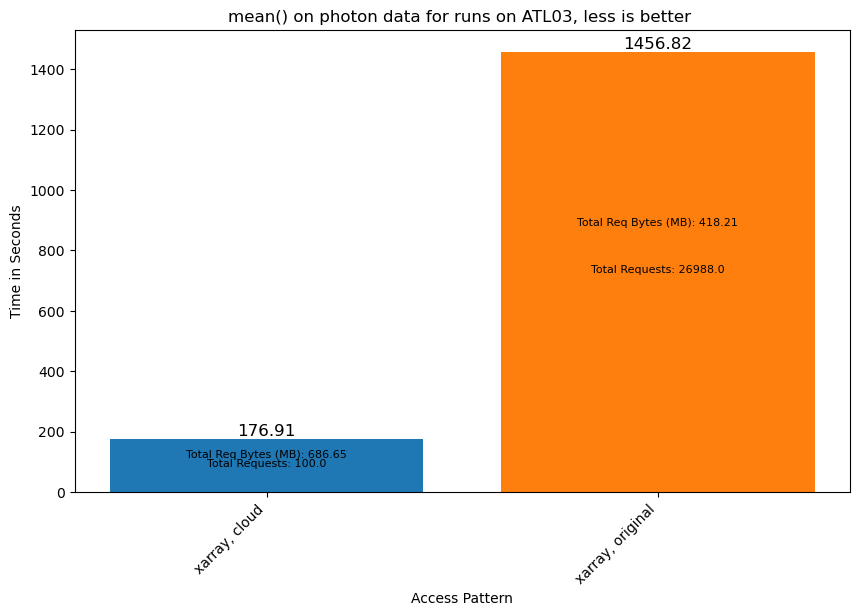

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in df.groupby(['library', 'format']):
    library, format = name
    x = f'{library}, {format}'
    y = group['time'].mean()
    ax.bar(f'{library}, {format}', group['time'].mean(), label=f'{library}, {format}', align='center')
    ax.text(x, y + 0.05, f'{group["time"].mean():.2f}', ha='center', va='bottom', color='black', fontsize=12)
    ax.text(x, y - (y/2) - 10, f'Total Requests: {group["total_requests"].mean()}', ha='center', va='bottom', color='black', fontsize=8)
    ax.text(x, y - (y/2.5), f'Total Req Bytes (MB): {round(group["total_requested_bytes"].mean() / (1024*1024) , 2)}', ha='center', va='bottom', color='black', fontsize=8)

# Set labels and title
ax.set_xlabel('Access Pattern')
ax.set_ylabel('Time in Seconds')
ax.set_title(f'mean() on photon data for runs on ATL03, less is better ')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# # Show legend
# ax.legend()

# Show the plot
with plt.xkcd():
    # This figure will be in XKCD-style
    fig1 = plt.figure()